## Background

The Quantum Approximate Optimization Algorithm (QAOA) is a hybrid iterative method for solving combinatorial optimization problems. In this tutorial, we demonstrate how to implement the QAOA algorithm using Qiskit Runtime for solving a simple max-cut problem.

In a max-cut problem, we want to partition nodes of a graph in a way that maximizes the number of edges between nodes in differing groups. The desired max-cut partition for the following graph is clear: the 0th-node on the left should be separated from the rest of the nodes on the right by a cut. We will find this answer by applying QAOA by using Qiskit Runtime primitives and sessions.


## Setup


In [3]:
# General imports
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

# SciPy minimizer routine
from scipy.optimize import minimize

# rustworkx graph library
import rustworkx as rx
from rustworkx.visualization import mpl_draw

In [4]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum", token="f94ac321cc1f3d4cdf4405497462612138aaf73f98fdd3b2f0bd5b763173925667a63bfee29a9f1314ca9901e26f3137b4f37df5f1ace14a1447312c12da7930")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_kyoto'

## Step 1: Map classical inputs to a quantum problem

To demonstrate max-cut, we'll create a graph using the [rustworkx library](https://github.com/Qiskit/rustworkx), and create Pauli Hamiltonian that encodes the cost in a manner such that the minimum expectation value of the operator corresponds to the maximum number of edges between the nodes in two different groups.


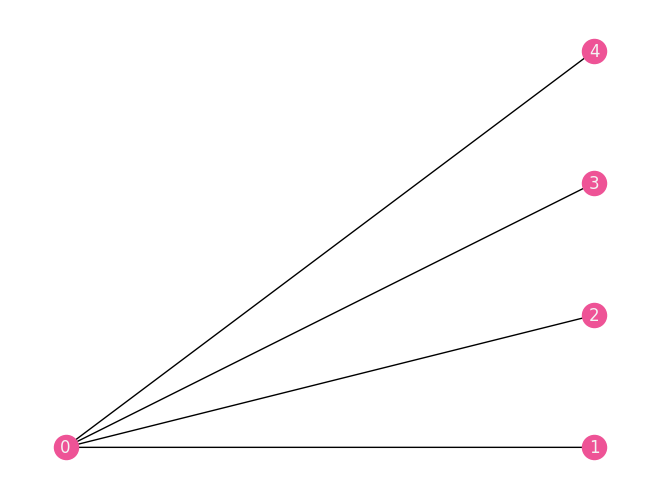

In [5]:
num_nodes = 5
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1)]

G = rx.PyGraph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)
mpl_draw(
    G, pos=rx.bipartite_layout(G, {0}), with_labels=True, node_color="#EE5396", font_color="#F4F4F4"
)

For this simple example, the operator is a linear combination of terms with `Z` operators on nodes connected by an edge (recall that the 0th qubit is farthest right): $IIIZZ + IIZIZ + IZIIZ + ZIIIZ$. Once the operator is constructed, the ansatz for the QAOA algorithm can easily be built by using the [`QAOAAnsatz`](https://docs.quantum-computing.ibm.com/api/qiskit/qiskit.circuit.library.QAOAAnsatz#qaoaansatz) circuit from the Qiskit circuit library.


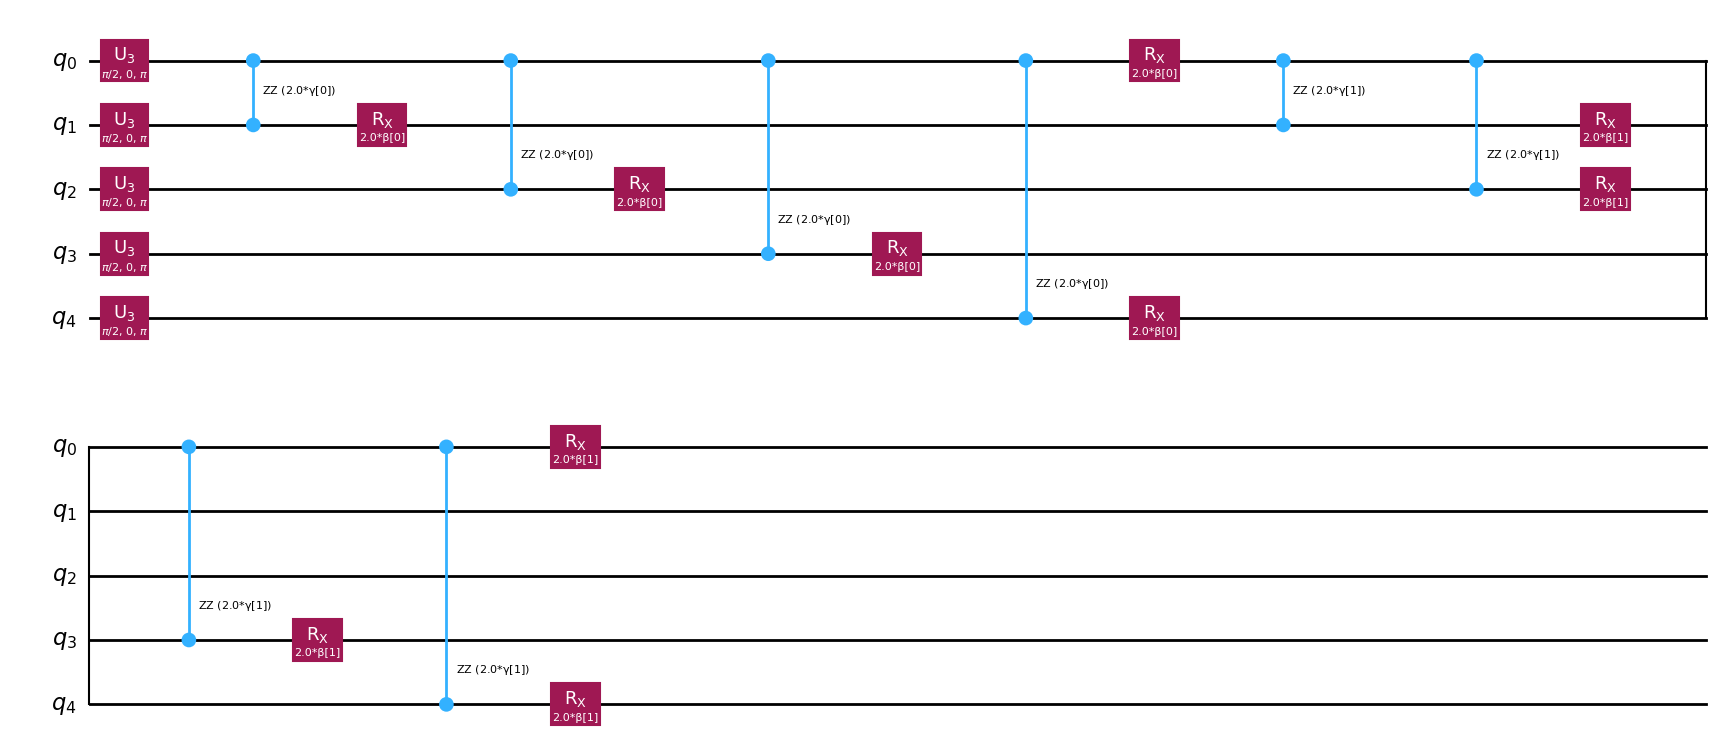

In [6]:
# Problem to Hamiltonian operator
hamiltonian = SparsePauliOp.from_list([("IIIZZ", 1), ("IIZIZ", 1), ("IZIIZ", 1), ("ZIIIZ", 1)])
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)

ansatz.decompose(reps=3).draw(output="mpl", style="iqp")

The previous image illustrates the ansatz in basic gates for clarity. However, it can be expressed in multiple levels of decomposition by changing the `reps` argument or by drawing the circuit without the `decompose` method. For example, the following representation directly shows the QAOA structure with the default `reps` value, which is `reps=1`.


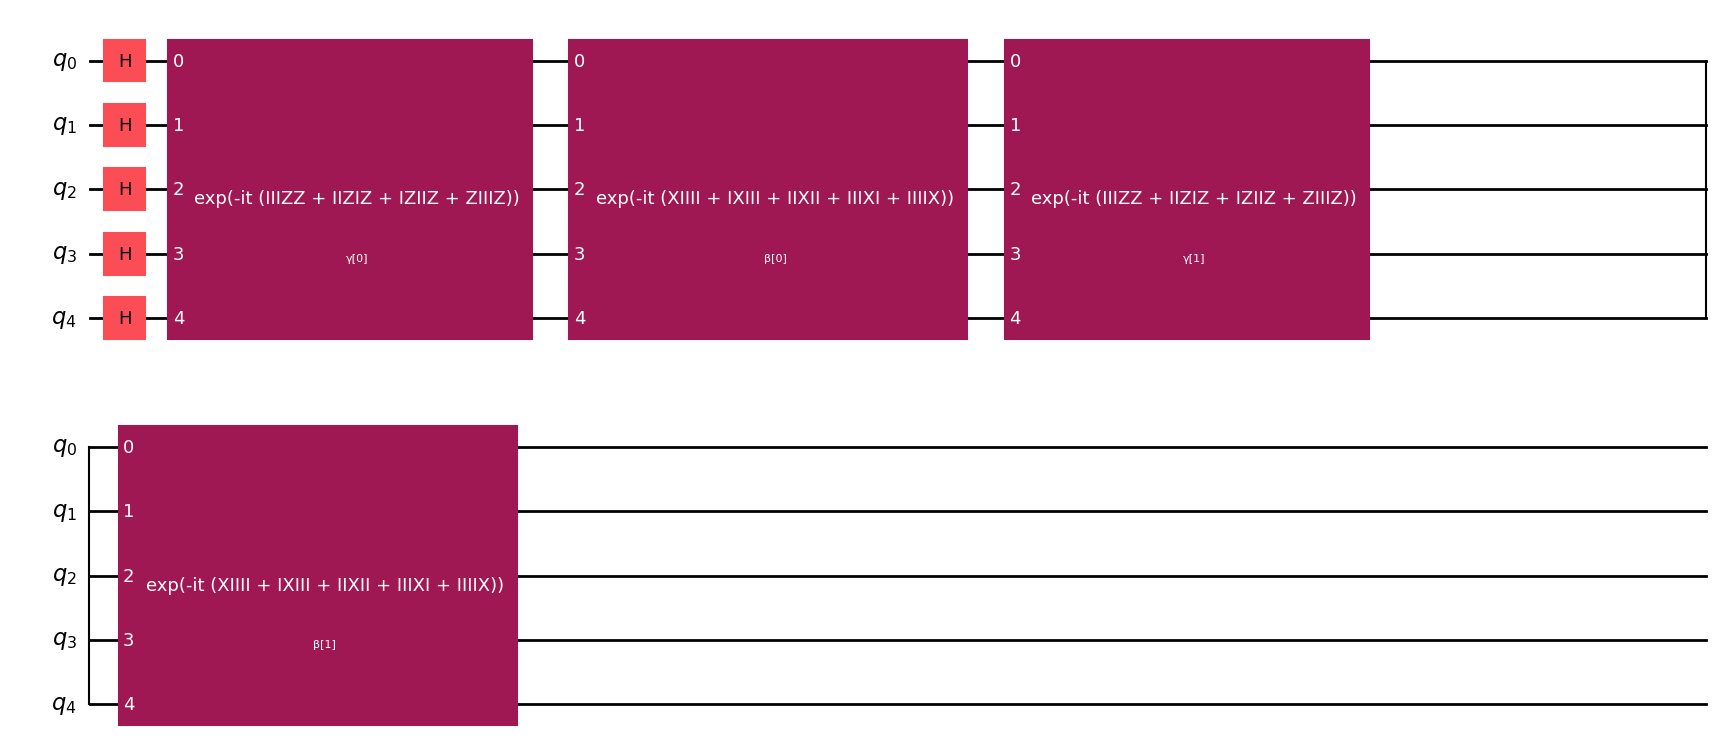

In [7]:
ansatz.decompose().draw(output="mpl", style="iqp")

## Step 2: Optimize problem for quantum execution.


To reduce the total job execution time, V2 primitives only accept circuits (ansatz) and observables (Hamiltonian) that conforms to the instructions and connectivity supported by the target system (referred to as instruction set architecture (ISA) circuits and observables).


### ISA Circuit


We can schedule a series of [`qiskit.transpiler`](https://docs.quantum-computing.ibm.com/api/qiskit/transpiler) passes to optimize our circuit for a selected backend and make it compatible with the instruction set architecture (ISA) of the backend. This can be easily done using a preset pass manager from `qiskit.transpiler` and its `optimization_level` parameter.

*   [`optimization_level`](https://docs.quantum-computing.ibm.com/api/qiskit/transpiler_preset#preset-pass-manager-generation): The lowest optimization level just does the bare minimum needed to get the circuit running on the device; it maps the circuit qubits to the device qubits and adds swap gates to allow all 2-qubit operations. The highest optimization level is much smarter and uses lots of tricks to reduce the overall gate count. Since multi-qubit gates have high error rates and qubits decohere over time, the shorter circuits should give better results.


In [8]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

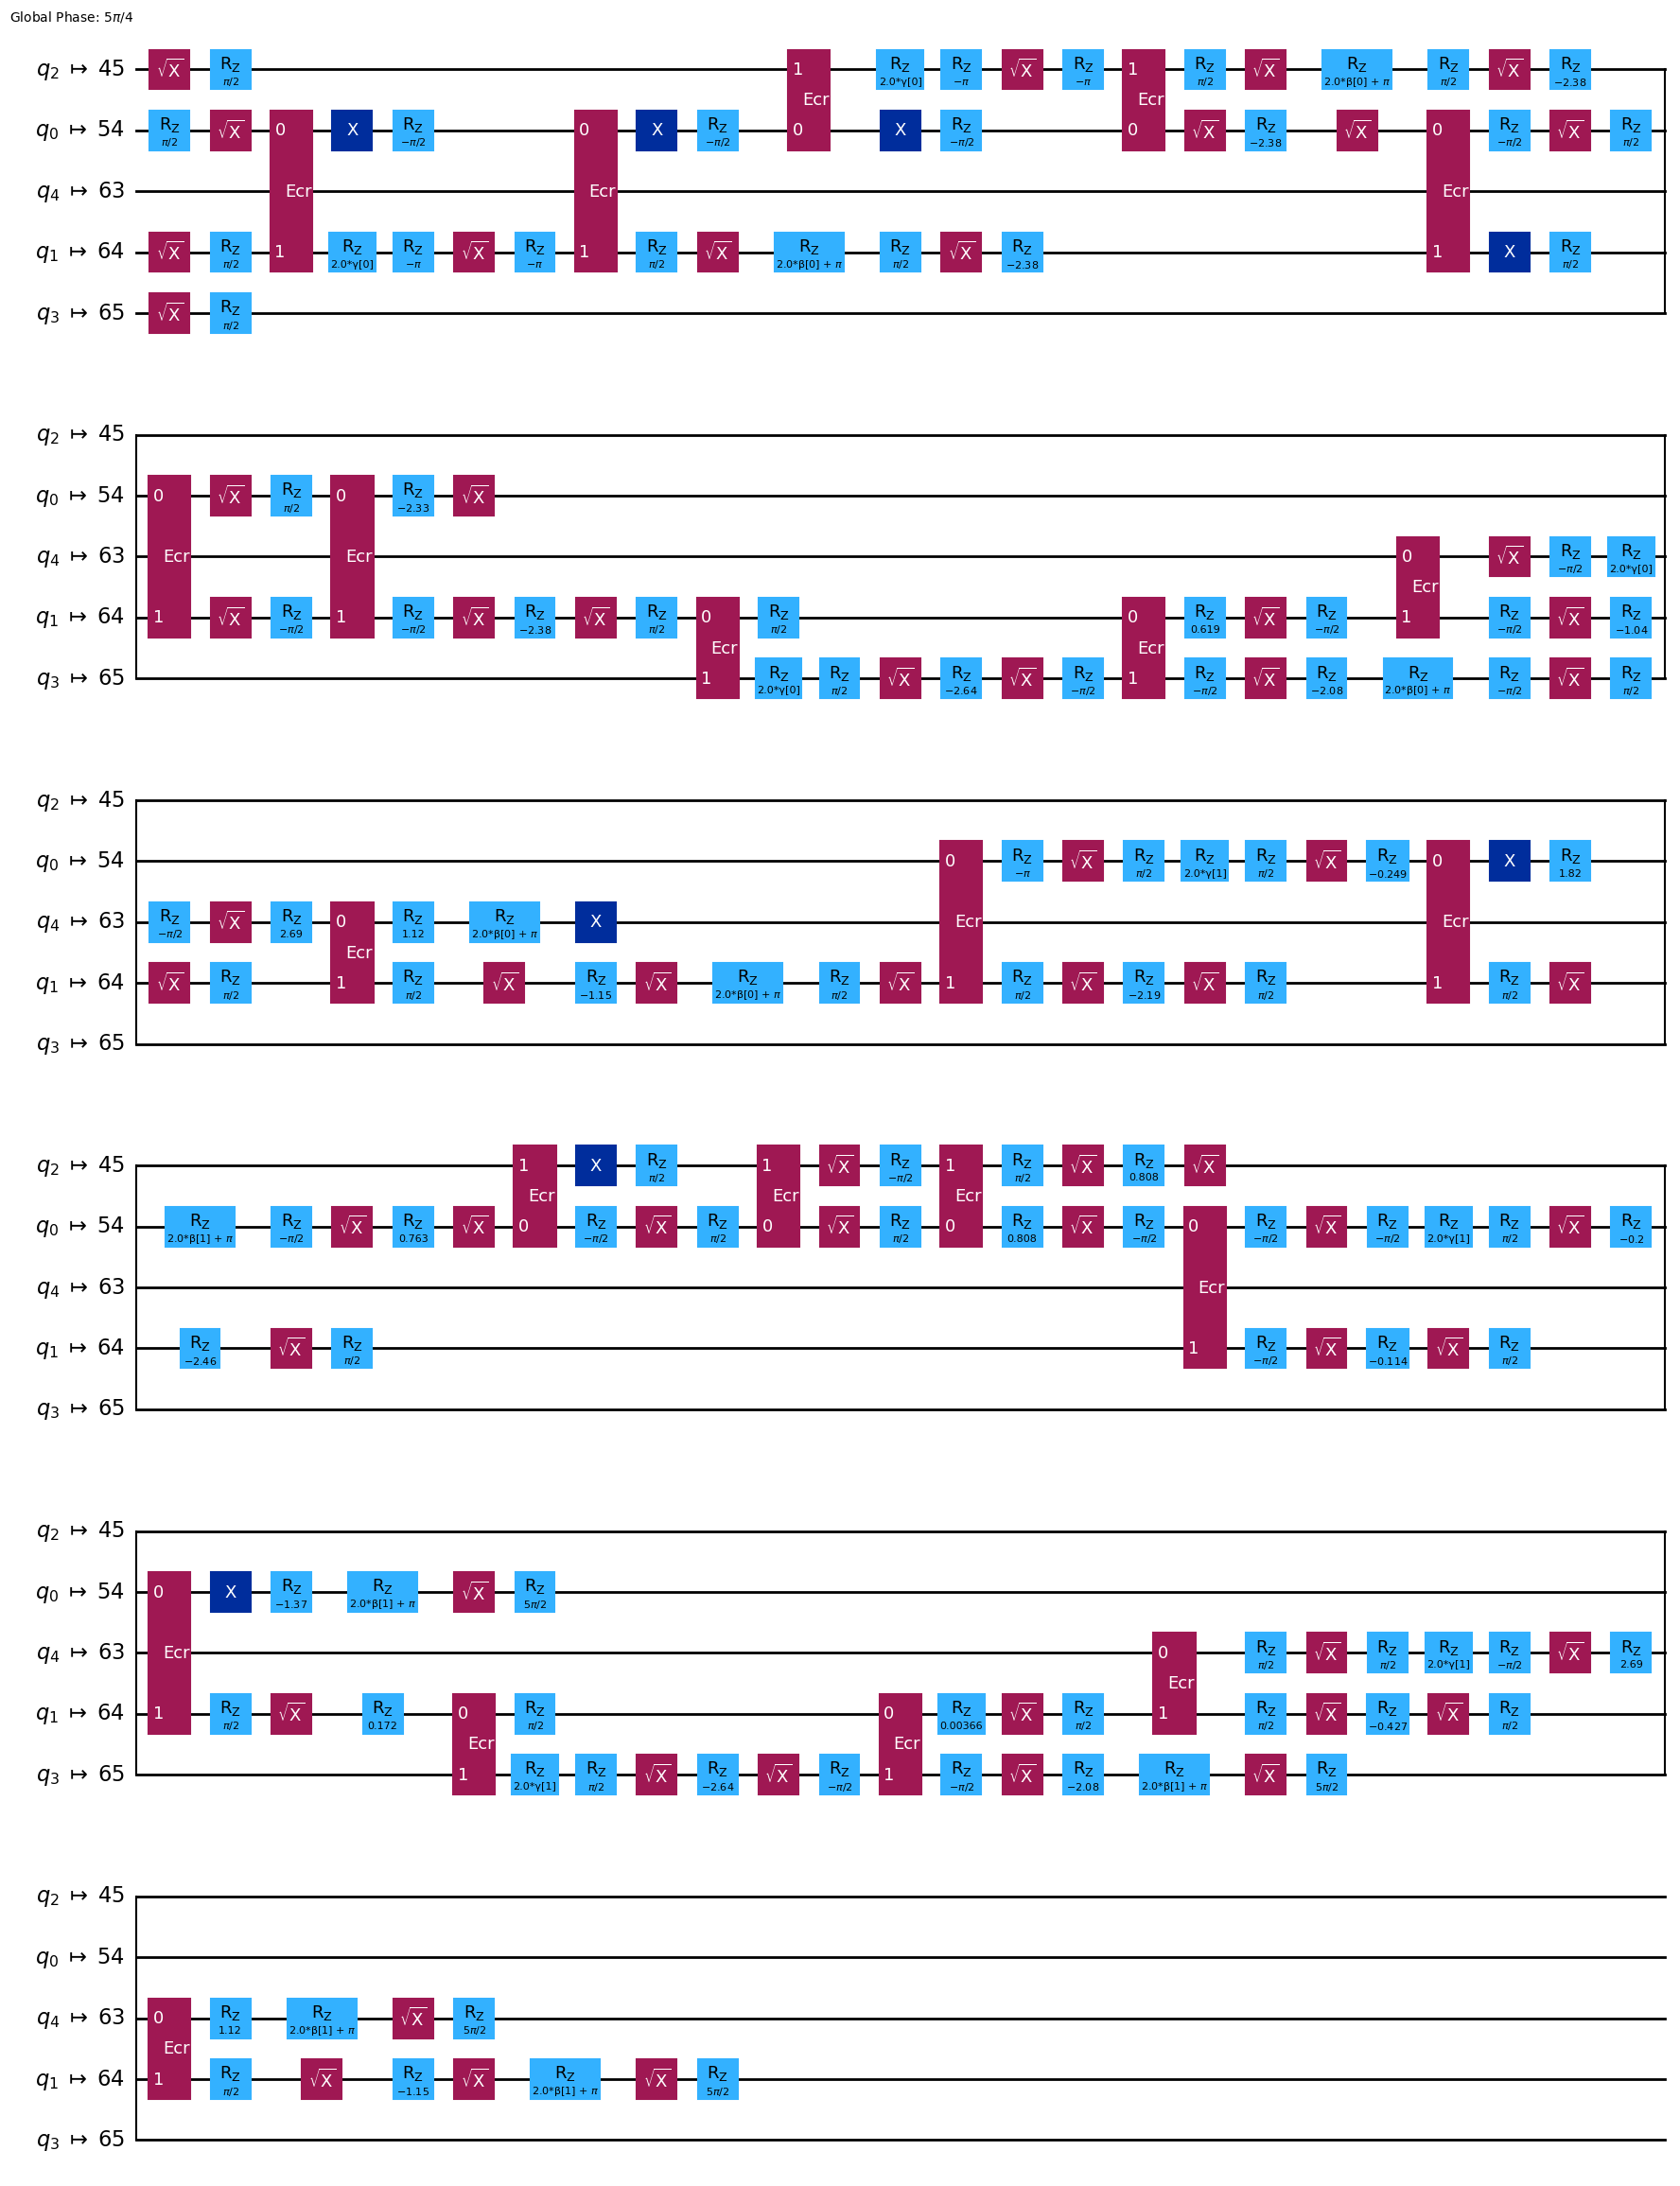

In [9]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

### ISA Observables


Similarly, we need to transform the Hamiltonian to make it backend compatible before running jobs with [`Runtime Estimator V2`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2#run). We can perform the transformation using the `apply_layout` the method of `SparsePauliOp` object.


In [10]:
hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)
hamiltonian_isa

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

## Step 3: Execute using Qiskit Primitives.


As with an iterative optimization procedure, we now need to define our cost function over which to minimize.  We proceed in an identical manner to the [Variational Quantum Eigensolver tutorial](https://learning.quantum-computing.ibm.com/tutorial/variational-quantum-eigensolver), computing the expectation value of our Hamiltonian with respect to the parameterized ansatz circuit using the [Qiskit Runtime `Estimator`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) primitive:


In [11]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]

    return cost

Any classical optimizer can be used to minimize the cost function. On a real quantum system, an optimizer designed for non-smooth cost function landscapes usually does better. Here we use the [COBYLA routine from SciPy through the minimize function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

Because we are iteratively executing many calls to Runtime, we use a [`Session`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Session) to execute all calls within a single block. Moreover, for QAOA, the solution is encoded in the output distribution of the ansatz circuit bound with the optimal parameters from the minimization. Therefore, we will need a [`Sampler`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.SamplerV2) primitive as well, and will instantiate it with the same [`Session`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Session).


In [12]:
# To run on local simulator:
#   1. Use the StatevectorEstimator from qiskit.primitives instead.
#   2. Remove the Session instantiation below.
session = Session(backend=backend)

# Configure estimator
estimator = Estimator(session=session)
estimator.options.default_shots = 10_000
estimator.options.dynamical_decoupling.enable = True

# Configure sampler
sampler = Sampler(session=session)
sampler.options.default_shots = 10_000
sampler.options.dynamical_decoupling.enable = True

We can set an initial set of random parameters:


In [13]:
x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)

We can run our minimization routine:


In [14]:
res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In the end, we have a result in the standard [SciPy `OptimizeResult`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html) format.


In [ ]:
res

## Step 4: Post-process, return result in classical format.


The solution vector of parameter angles (`x`), when plugged into the `ansatz` circuit, yields the graph partitioning that we were looking for.


In [ ]:
# Assign solution parameters to ansatz
qc = ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()
qc_isa = pm.run(qc)
qc_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [ ]:
result = sampler.run([qc_isa]).result()
samp_dist = result[0].data.meas.get_counts()
# Close the session since we are now done with it
session.close()

For small problem instances, the solution can be visually obtained:


In [ ]:
plot_distribution(samp_dist, figsize=(15, 5))

The most probable bit-strings, up to finite-sampling deviations, encode the solution.  Here we see that `00001` and `11110` are found, and are indeed correct.  There are two solutions because the labeling of the two partitions with `'0'` or `'1'` is arbitrary.


In [ ]:
# Reverse 11110 to convert quantum result to classical solution
solution = [0, 1, 1, 1, 1]

mpl_draw(
    G,
    pos=rx.bipartite_layout(G, {0}),
    with_labels=True,
    node_color=["#EE5396" if kk else "#0F62FE" for kk in solution],
    font_color="#F4F4F4",
)

In [16]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.22.0'

In [15]:
import qiskit

qiskit.version.get_version_info()

'1.0.2'